In [33]:
import scanpy as sc
import sys
sys.path.append("../")
import trvaep
from trvaep import pl
import numpy as np

## loading and preparing data 

In [67]:
adata = sc.read("../data/kang_seurat.h5ad", backup_url="shorturl.at/tNS17")
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:, adata.var['highly_variable']]
n_conditions = adata.obs["condition"].unique().shape[0]
condition_key="condition"

In [68]:
adata_train = adata[~((adata.obs["cell_type"] == "pDC")
                      & (adata.obs[condition_key] == "CTRL"))]

In [ ]:
sc.pp.neighbors(adata_train)
sc.tl.umap(adata_train)


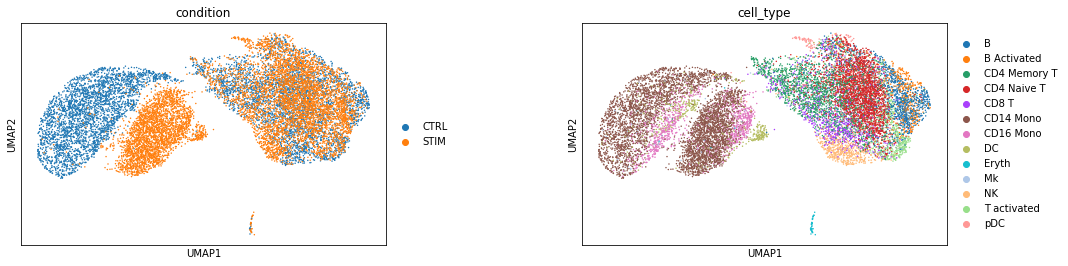

In [15]:
sc.pl.umap(adata_train, color=[condition_key, "cell_type"], wspace=.4)

## creating model object 

In [69]:
model = trvaep.CVAE(adata_train.n_vars, num_classes=n_conditions,
            encoder_layer_sizes=[64, 32], decoder_layer_sizes=[64, 32], latent_dim=10, alpha=0.0001,
            use_mmd=True, beta=5, output_activation="ReLU")

### Make a trainer object 

note that `condition_key`  is the label of your data (e.g. batch, treatment)

In [70]:
trainer = trvaep.Trainer(model, adata_train, condition_key=condition_key)

In [71]:
trainer.train_trvae(300, 512, early_patience=50)

Epoch 00/300 Batch 0000/23, Loss:  299.2489, rec_loss:  297.9362, KL_loss:    0.0001, MMD_loss:     1.3127
Epoch 00/300 Batch 0023/23, Loss:  207.8283, rec_loss:  206.7128, KL_loss:    0.0001, MMD_loss:     1.1154
Epoch 01/300 Batch 0000/23, Loss:  204.0368, rec_loss:  202.8433, KL_loss:    0.0001, MMD_loss:     1.1935
Epoch 01/300 Batch 0023/23, Loss:  168.2673, rec_loss:  166.9193, KL_loss:    0.0001, MMD_loss:     1.3479
Epoch 02/300 Batch 0000/23, Loss:  171.5304, rec_loss:  170.3698, KL_loss:    0.0001, MMD_loss:     1.1604
Epoch 02/300 Batch 0023/23, Loss:  158.8745, rec_loss:  157.7662, KL_loss:    0.0002, MMD_loss:     1.1081
Epoch 03/300 Batch 0000/23, Loss:  151.3112, rec_loss:  150.2594, KL_loss:    0.0002, MMD_loss:     1.0516
Epoch 03/300 Batch 0023/23, Loss:  147.4505, rec_loss:  146.4174, KL_loss:    0.0004, MMD_loss:     1.0327
Epoch 04/300 Batch 0000/23, Loss:  135.4862, rec_loss:  134.4116, KL_loss:    0.0004, MMD_loss:     1.0742
Epoch 04/300 Batch 0023/23, Loss:  12

## visualizing the MMD latent space

... storing 'cell_type' as categorical
... storing 'condition' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


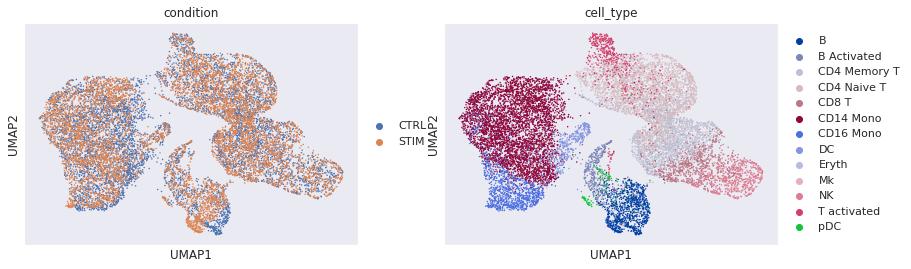

In [72]:
latent_y = model.get_y(
    adata.X.A, model.label_encoder.transform(adata.obs[condition_key]))
adata_latent = sc.AnnData(latent_y)
adata_latent.obs["cell_type"] = adata.obs["cell_type"].tolist()
adata_latent.obs[condition_key] = adata.obs[condition_key].tolist()
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color=[condition_key, "cell_type"])

## Making prediction

layers are inconsistent - only layers that are shared among all AnnData objects are included.
... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'orig.ident' as categorical
... storing 'seurat_annotations' as categorical
... storing 'stim' as categorical
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its len

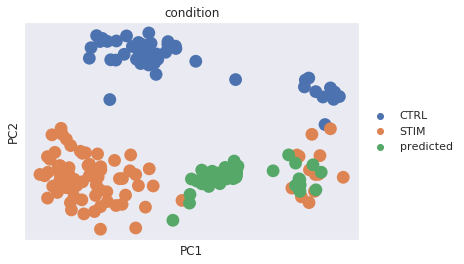

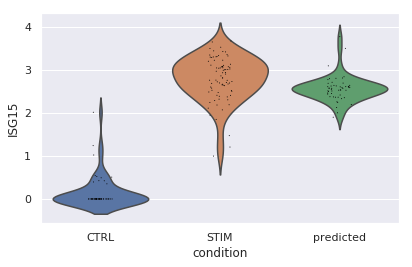

In [73]:
ground_truth = adata[(adata.obs["cell_type"] == "pDC")]
adata_source = adata[(adata.obs["cell_type"] == "pDC") &
                     (adata.obs[condition_key] == "CTRL")]
predicted_data = model.predict(x=adata_source.X.A, y=adata_source.obs[condition_key].tolist(),
                               target="STIM")
adata_pred = sc.AnnData(predicted_data)
adata_pred.obs[condition_key] = np.tile("predicted", len(adata_pred))
adata_pred.var_names = adata_source.var_names.tolist()
all_adata = ground_truth.concatenate(adata_pred)
sc.tl.pca(all_adata)
sc.pl.pca(all_adata, color=[condition_key])
sc.pl.violin(all_adata, keys="ISG15", groupby="condition")

## Mean correlation plot


In [74]:
sc.tl.rank_genes_groups(ground_truth, groupby="condition", method="wilcoxon")
diff_genes = ground_truth.uns["rank_genes_groups"]["names"]["STIM"]

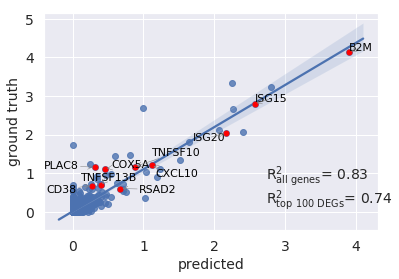

In [75]:
r2_value = pl.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={
                                            "x": "predicted", "y": "STIM"},
                                        gene_list=diff_genes[:10],
                                        top_100_genes= diff_genes,
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)

### Get batch corrected data in output space for all data 

`target` can be the batch or the condition that you want your data to be mapped on it.

In [76]:
predicted_data = model.predict(x=adata.X.A, y=adata.obs[condition_key].tolist(),
                               target="STIM")

In [77]:
corrected = sc.AnnData(predicted_data)
corrected.obs["cell_type"] = adata.obs["cell_type"].tolist()
corrected.obs[condition_key] = adata.obs[condition_key].tolist()

In [78]:
sc.pp.neighbors(corrected)
sc.tl.umap(corrected)

         Falling back to preprocessing with `sc.pp.pca` and default params.


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


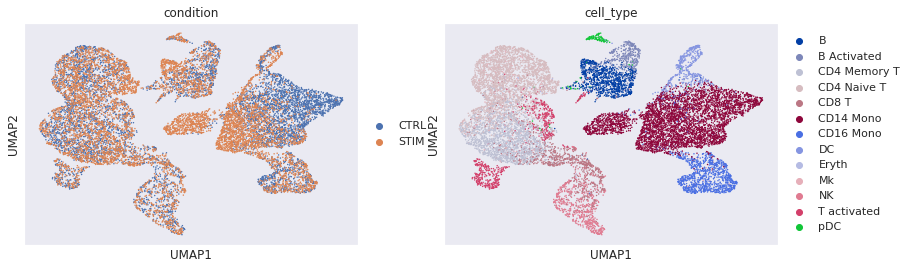

In [82]:
sc.pl.umap(corrected, color=[condition_key, "cell_type"])